###                                                                Lab 1

##### Lev-Fedir Lysyk, Maxim-Vasyl Tarnavskyi

##### Goal: familiarise ourselves with different algorithms related to weighted graphs and their implementation in code.

##### Problem: Implement Kruskal, Prim, Bellman-Ford and Floyd-Warshall algorithms with python and compare them to their versions in networkx.

In [31]:
import random
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations, groupby
import time

## Generating graph

In [32]:
# You can use this function to generate a random graph with 'num_of_nodes' nodes
# and 'completeness' probability of an edge between any two nodes
# If 'directed' is True, the graph will be directed
# If 'draw' is True, the graph will be drawn
def gnp_random_connected_graph(num_of_nodes: int,
                               completeness: int,
                               directed: bool = False,
                               draw: bool = False):
    """
    Generates a random graph, similarly to an Erdős-Rényi 
    graph, but enforcing that the resulting graph is conneted (in case of undirected graphs)
    """

    
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    edges = combinations(range(num_of_nodes), 2)
    G.add_nodes_from(range(num_of_nodes))
    
    for _, node_edges in groupby(edges, key = lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        if random.random() < 0.5:
            random_edge = random_edge[::-1]
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < completeness:
                G.add_edge(*e)
                
    for (u,v,w) in G.edges(data=True):
        w['weight'] = random.randint(-5, 20)
                
    if draw: 
        plt.figure(figsize=(10,6))
        if directed:
            # draw with edge weights
            pos = nx.arf_layout(G)
            nx.draw(G,pos, node_color='lightblue', 
                    with_labels=True,
                    node_size=500, 
                    arrowsize=20, 
                    arrows=True)
            labels = nx.get_edge_attributes(G,'weight')
            nx.draw_networkx_edge_labels(G, pos,edge_labels=labels)
            
        else:
            nx.draw(G, node_color='lightblue', 
                with_labels=True, 
                node_size=500)
        
    return G

### Function for time comparison

In [33]:
def time_algorithm(nxs: callable, our: callable, comparing_range: range, NUM_OF_ITERATIONS: int, directed: bool, algorithm1: str = None, fullness: float = 0.5) -> None:
    '''
    returns a dictionary with keys as number of nodes and values as time needed to finish
    '''
    times_our = {}
    times_nxs = {}
    for n in comparing_range:
        time_nxs_taken = 0
        time_our_taken = 0
        for i in range(NUM_OF_ITERATIONS):
            G = gnp_random_connected_graph(n, fullness, directed)
            if algorithm1 in ["kruskal", "prim"]:
                start = time.time()
                nxs(G, algorithm=algorithm1)
                end = time.time()
            elif algorithm1 == "bellman_ford":
                start = time.time()
                try:
                    nxs(G, 0)
                except:
                    pass
                end = time.time()
            else:
                start = time.time()
                nxs(G)
                end = time.time()
            time_nxs_taken += end - start

            start = time.time()
            our(G)
            end = time.time()
            time_our_taken += end - start

        times_nxs[n] = time_nxs_taken / NUM_OF_ITERATIONS * 1000
        times_our[n] = time_our_taken / NUM_OF_ITERATIONS * 1000
    return times_nxs, times_our


# For Task 1

## Kruskal's algorithm

In [4]:
from networkx.algorithms import tree

In [5]:
def custom_kruskal(G: nx.Graph) -> nx.Graph:
    '''
    kruskal algorithm.
    returns minimum spanning tree as a nx graph
    '''
    g_edges = sorted(G.edges(data=True), key=lambda info: info[2]['weight'])
    edges_weight = {frozenset(edge[:2]): edge[2]['weight'] for edge in g_edges}
    K = nx.create_empty_copy(G)
    v = [{node} for node in G.nodes]
    v_len = len(v)
    for edge, w in edges_weight.items():
        for i, nodes in enumerate(v):
            in_set = edge.intersection(nodes)
            if len(in_set) == 1:
                not_in_set = edge.difference(nodes)
                node2, = not_in_set
                for i2 in range(i + 1, v_len):
                    if node2 in v[i2]:
                        K.add_edge(*edge, weight=w)
                        v[i].update(v.pop(i2))
                        v_len -= 1
                        break
                break
    return K

## Comparison
### Our Kruskal vs networkx's Kruskal

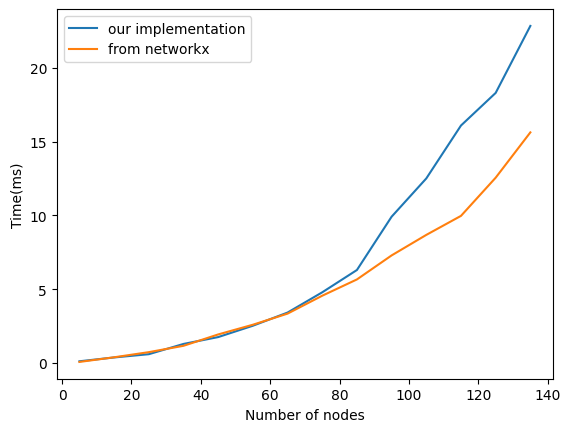

In [9]:
# Overall comparison with different amounts of nodes.

times_nxs, times_our = time_algorithm(tree.minimum_spanning_tree, custom_kruskal, range(5, 140, 10), 1000, False, "kruskal")
times_nxs, times_our = times_nxs.items(), times_our.items()
x1, y1 = zip(*times_our)
x2, y2 = zip(*times_nxs)
plt.plot(x1, y1, label="our implementation")
plt.plot(x2, y2, label="from networkx")
ylabel = plt.ylabel("Time(ms)")
xlabel = plt.xlabel("Number of nodes")
legend = plt.legend()

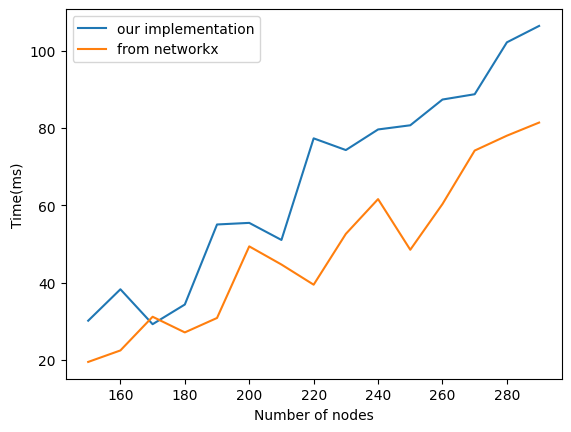

In [10]:
#Smaller comparison for an average fullness and a high amount of modes.

times_nxs, times_our = time_algorithm(tree.minimum_spanning_tree, custom_kruskal, range(150, 300, 10), 50, False, "kruskal")
times_nxs, times_our = times_nxs.items(), times_our.items()
x1, y1 = zip(*times_our)
x2, y2 = zip(*times_nxs)
plt.plot(x1, y1, label="our implementation")
plt.plot(x2, y2, label="from networkx")
ylabel = plt.ylabel("Time(ms)")
xlabel = plt.xlabel("Number of nodes")
legend = plt.legend()

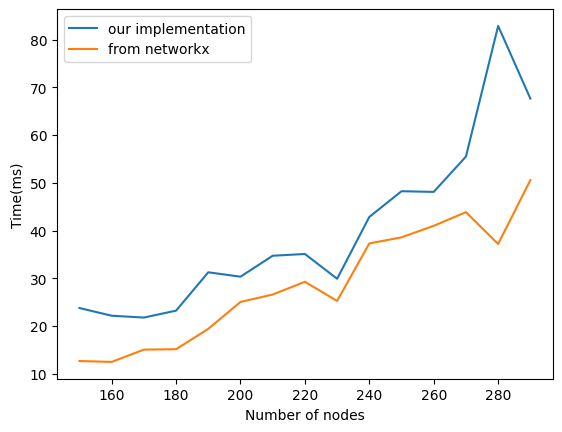

In [13]:
#Smaller comparison for a low edge density and a high amount of nodes.

times_nxs, times_our = time_algorithm(tree.minimum_spanning_tree, custom_kruskal, range(150, 300, 10), 50, False, "kruskal", 0.3)
times_nxs, times_our = times_nxs.items(), times_our.items()
x1, y1 = zip(*times_our)
x2, y2 = zip(*times_nxs)
plt.plot(x1, y1, label="our implementation")
plt.plot(x2, y2, label="from networkx")
ylabel = plt.ylabel("Time(ms)")
xlabel = plt.xlabel("Number of nodes")
legend = plt.legend()

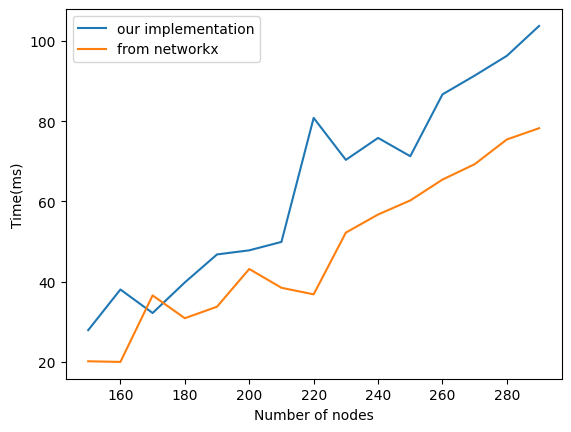

In [12]:
#Smaller comparison for a high edge density and a high amount of nodes.

times_nxs, times_our = time_algorithm(tree.minimum_spanning_tree, custom_kruskal, range(150, 300, 10), 50, False, "kruskal")
times_nxs, times_our = times_nxs.items(), times_our.items()
x1, y1 = zip(*times_our)
x2, y2 = zip(*times_nxs)
plt.plot(x1, y1, label="our implementation")
plt.plot(x2, y2, label="from networkx")
ylabel = plt.ylabel("Time(ms)")
xlabel = plt.xlabel("Number of nodes")
legend = plt.legend()

### Conclusion:
##### Looking at the above graphs, we can conclude that our Kruscal algorithm is a little slower, but still operates in approximately the same time complexity. The difference in speed seems to be quite constant with different edge density, and, unsurprisingly, increases with the increase of the amount of nodes in the graph.

## Prim's algorithm

In [14]:
def custom_prim(graph):
    '''
    Prim algorithm for undirected graphs.
    '''
    result = nx.Graph()
    result.add_node(0)
    possib = {node : (graph[0][node]['weight'], 0) if node in graph[0]\
            else (float('inf'), None) for node in graph.nodes if node}
    while result.nodes != graph.nodes:
        new = min(possib, key = possib.get)
        new_value = possib[new]
        del possib[new]
        result.add_edge(*sorted([new, new_value[1]]), weight = new_value[0])
        for u, v, w in graph.edges(new, data = True):
            other = u if u != new else v
            if other in possib and possib[other][0] > w['weight']:
                possib[other] = (w['weight'], new)

    return result

## Comparison
### Our Prim vs networkx's Prim

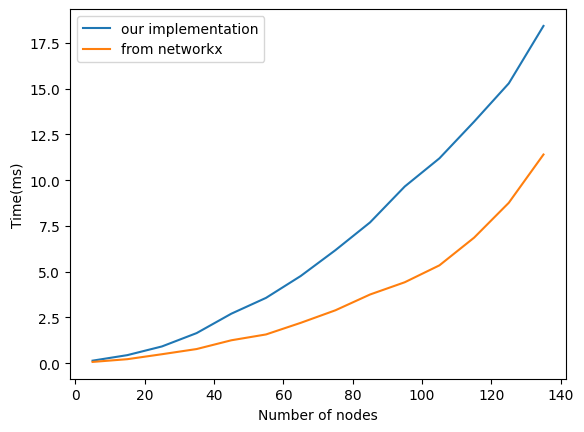

In [15]:
# Overall comparison with different amounts of nodes.

times_nxs, times_our = time_algorithm(tree.minimum_spanning_tree, custom_prim, range(5, 140, 10), 1000, False, "prim")
times_nxs, times_our = times_nxs.items(), times_our.items()
x1, y1 = zip(*times_our)
x2, y2 = zip(*times_nxs)
plt.plot(x1, y1, label="our implementation")
plt.plot(x2, y2, label="from networkx")
ylabel = plt.ylabel("Time(ms)")
xlabel = plt.xlabel("Number of nodes")
legend = plt.legend()

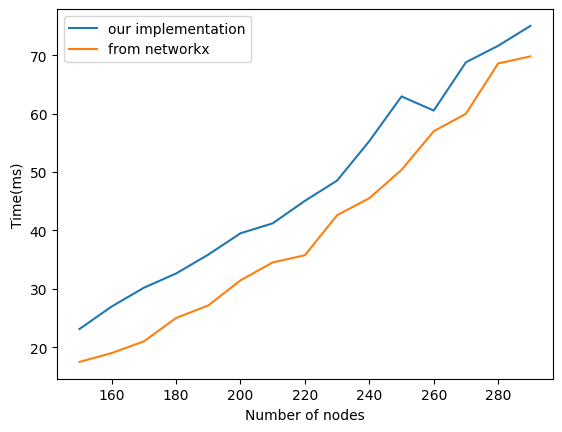

In [16]:
#Smaller comparison for an average fullness and a high amount of nodes.

times_nxs, times_our = time_algorithm(tree.minimum_spanning_tree, custom_prim, range(150, 300, 10), 50, False, "prim")
times_nxs, times_our = times_nxs.items(), times_our.items()
x1, y1 = zip(*times_our)
x2, y2 = zip(*times_nxs)
plt.plot(x1, y1, label="our implementation")
plt.plot(x2, y2, label="from networkx")
ylabel = plt.ylabel("Time(ms)")
xlabel = plt.xlabel("Number of nodes")
legend = plt.legend()

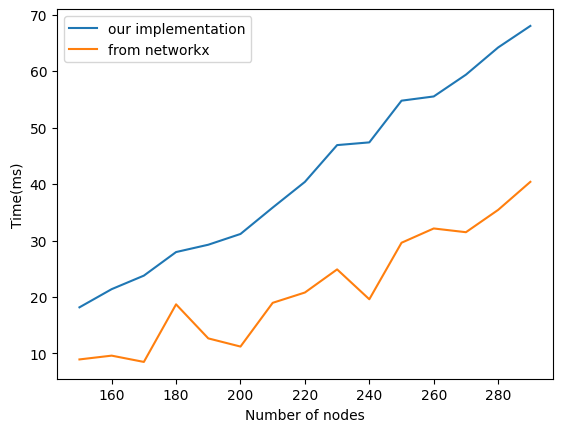

In [17]:
#Smaller comparison for a low edge density and a high amount of nodes.

times_nxs, times_our = time_algorithm(tree.minimum_spanning_tree, custom_prim, range(150, 300, 10), 50, False, "prim", 0.3)
times_nxs, times_our = times_nxs.items(), times_our.items()
x1, y1 = zip(*times_our)
x2, y2 = zip(*times_nxs)
plt.plot(x1, y1, label="our implementation")
plt.plot(x2, y2, label="from networkx")
ylabel = plt.ylabel("Time(ms)")
xlabel = plt.xlabel("Number of nodes")
legend = plt.legend()

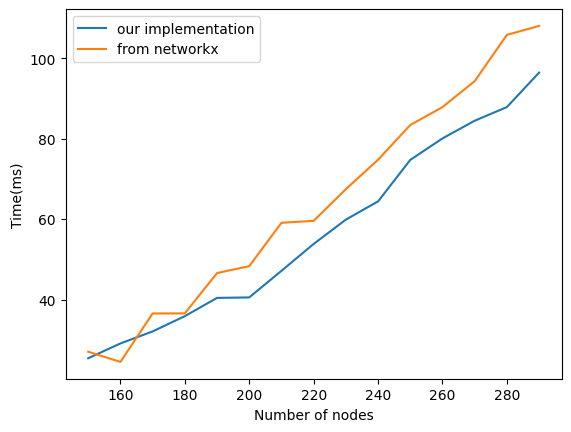

In [18]:
#Smaller comparison for a high edge density and a high amount of nodes.

times_nxs, times_our = time_algorithm(tree.minimum_spanning_tree, custom_prim, range(150, 300, 10), 50, False, "prim", 0.8)
times_nxs, times_our = times_nxs.items(), times_our.items()
x1, y1 = zip(*times_our)
x2, y2 = zip(*times_nxs)
plt.plot(x1, y1, label="our implementation")
plt.plot(x2, y2, label="from networkx")
ylabel = plt.ylabel("Time(ms)")
xlabel = plt.xlabel("Number of nodes")
legend = plt.legend()

### Conclusion:
##### Quite similarly to the Kruskal's algorithm experiment, our implementation seems to be somewhat slower than the one from networkx, but it still gets quite close. Compared to the previous case, however, the difference in speed is noticeable even on very small graphs. Our implementation seems to be particularly slow with low edge density. We think that the main difference between our variant and the one from networkx is that their implementation involves less iterating over nodes compared to ours.

# Task 2

## Bellman-Ford algorithm

In [19]:
from networkx.algorithms import bellman_ford_predecessor_and_distance

In [21]:
def custom_bellman_ford(G: nx.DiGraph) -> nx.DiGraph:
    '''
    Bellman Ford's Algorithm
    returns predecessors and distances
    '''
    node_edge = {}
    if isinstance(G, nx.DiGraph):
        for edge_info in G.edges(data=True):
            edge = edge_info[:2]
            weight = edge_info[2]['weight']
            if edge[0] not in node_edge:
                node_edge[edge[0]] = {edge: weight}
            else:
                node_edge[edge[0]] |= {edge: weight}
    else:
        for edge_info in G.edges(data=True):
            edge = edge_info[:2]
            weight = edge_info[2]['weight']
            if edge[0] not in node_edge:
                node_edge[edge[0]] = {edge: weight, edge[::-1]: weight}
            else:
                node_edge[edge[0]] |= {edge: weight, edge[::-1]: weight}

    dist = {node: float('inf') if node else 0 for node in G.nodes}
    pred = {node: [] for node in G.nodes}
    if 0 not in node_edge:
        changed = [min(node_edge)]
    else:
        changed = [0]
    count_nodes = len(G.nodes)
    i = 0
    while changed:
        new_dist = dict(dist.items())
        old_changed = changed[::]
        changed = []
        for node1 in old_changed:
            for edge, weight in node_edge[node1].items():
                dist2 = dist[node1] + weight
                if new_dist[edge[1]] > dist2:
                    new_dist[edge[1]] = dist2
                    pred[edge[1]] = [node1]
                    if edge[1] in node_edge:
                        changed.append(edge[1])
                elif new_dist[edge[1]] == dist2 and node1 not in pred[edge[1]]:
                    pred[edge[1]].append(node1)
        i += 1
        if i > count_nodes:
            return None
        dist = new_dist
    return {key: value for key, value in pred.items() if value or key == 0}\
        , {key: value for key, value in new_dist.items() if value != "inf"}

## Comparison
### Our Bellman Ford vs networkx's Bellman Ford

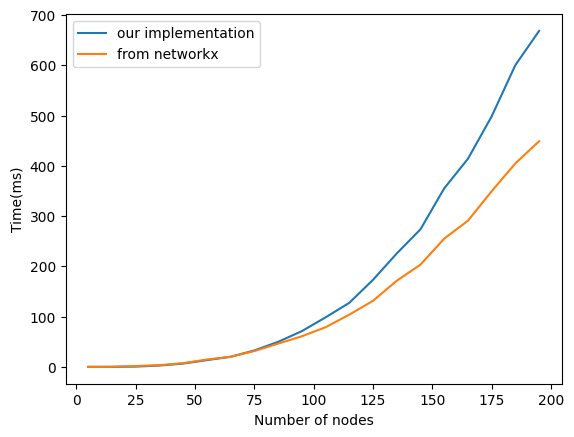

In [23]:
# Overall comparison with different amounts of nodes.

times_nxs, times_our = time_algorithm(bellman_ford_predecessor_and_distance, custom_bellman_ford, range(5, 200, 10), 30, True, "bellman_ford")
times_nxs, times_our = times_nxs.items(), times_our.items()
x1, y1 = zip(*times_our)
x2, y2 = zip(*times_nxs)
plt.plot(x1, y1, label="our implementation")
plt.plot(x2, y2, label="from networkx")
ylabel = plt.ylabel("Time(ms)")
xlabel = plt.xlabel("Number of nodes")
legend = plt.legend()

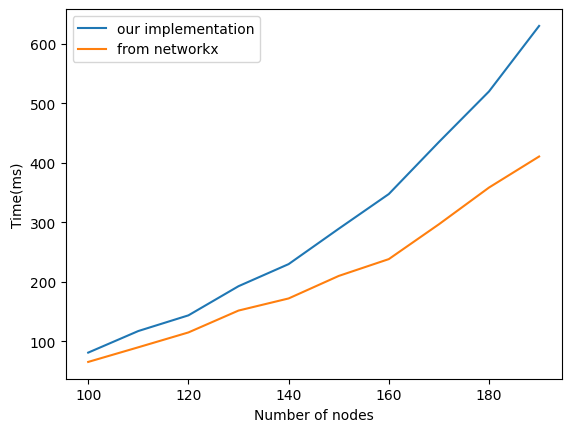

In [24]:
#Smaller comparison with average fullness.

times_nxs, times_our = time_algorithm(bellman_ford_predecessor_and_distance, custom_bellman_ford, range(100, 200, 10), 15, True, "bellman_ford")
times_nxs, times_our = times_nxs.items(), times_our.items()
x1, y1 = zip(*times_our)
x2, y2 = zip(*times_nxs)
plt.plot(x1, y1, label="our implementation")
plt.plot(x2, y2, label="from networkx")
ylabel = plt.ylabel("Time(ms)")
xlabel = plt.xlabel("Number of nodes")
legend = plt.legend()

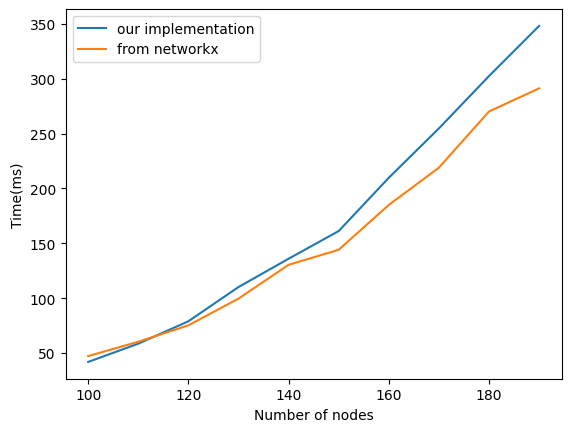

In [25]:
#Smaller comparison with low edge density.

times_nxs, times_our = time_algorithm(bellman_ford_predecessor_and_distance, custom_bellman_ford, range(100, 200, 10), 15, True, "bellman_ford", 0.3)
times_nxs, times_our = times_nxs.items(), times_our.items()
x1, y1 = zip(*times_our)
x2, y2 = zip(*times_nxs)
plt.plot(x1, y1, label="our implementation")
plt.plot(x2, y2, label="from networkx")
ylabel = plt.ylabel("Time(ms)")
xlabel = plt.xlabel("Number of nodes")
legend = plt.legend()

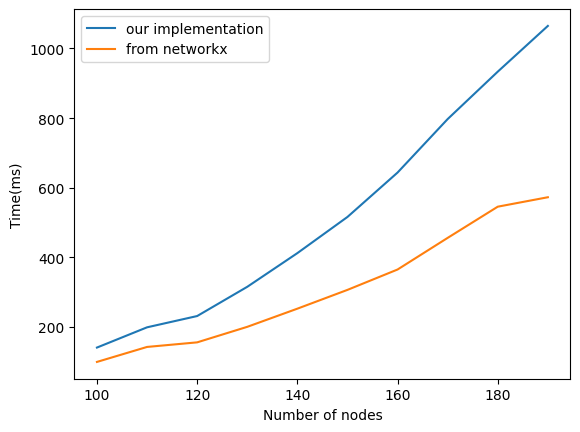

In [26]:
#Smaller comparison with high edge density.

times_nxs, times_our = time_algorithm(bellman_ford_predecessor_and_distance, custom_bellman_ford, range(100, 200, 10), 15, True, "bellman_ford", 0.8)
times_nxs, times_our = times_nxs.items(), times_our.items()
x1, y1 = zip(*times_our)
x2, y2 = zip(*times_nxs)
plt.plot(x1, y1, label="our implementation")
plt.plot(x2, y2, label="from networkx")
ylabel = plt.ylabel("Time(ms)")
xlabel = plt.xlabel("Number of nodes")
legend = plt.legend()

### Conclusion:
##### Our implementation of Bellman-Ford is, as in all the previous experiments, slightly worse than the one from networkx. It gets quite close to the one from the module when operating on a small amount of nodes though. When testing different node densities, we can see that our algorithm performs worse the more edges there are in a graph. Probably, the implementation from networkx has a more efficient way of iterating through them.

## Floyd-Warshall algorithm

In [34]:
from networkx.algorithms import floyd_warshall_predecessor_and_distance

In [35]:
def custom_floyd_warshall(graph):
    '''
    Floyd-warshall algorithm for directed graphs.
    '''
    pred = {u: {v: u for v in graph.nodes if graph.has_edge(u, v)}\
            for u in graph.nodes}
    dist = {u: {v: graph[u][v]['weight'] if graph.has_edge(u, v) else float('inf') if u != v else 0\
             for v in graph.nodes} for u in graph.nodes}
    for iter in range(len(dist)):
        for j in range(len(dist)):
            if dist[j][iter] == float('inf') or j == iter:
                continue
            for i in range(len(dist)):
                if dist[j][i] > dist[j][iter] + dist[iter][i]:
                    dist[j][i] = dist[j][iter] + dist[iter][i]
                    pred[j][i] = pred[iter][i]
                if i == j and dist[j][i] < 0:
                    return None
    return {key: value for key, value in pred.items() if value}, dist


## Comparison
### Our Floyd-Warshal vs networx's Floyd-Warshal

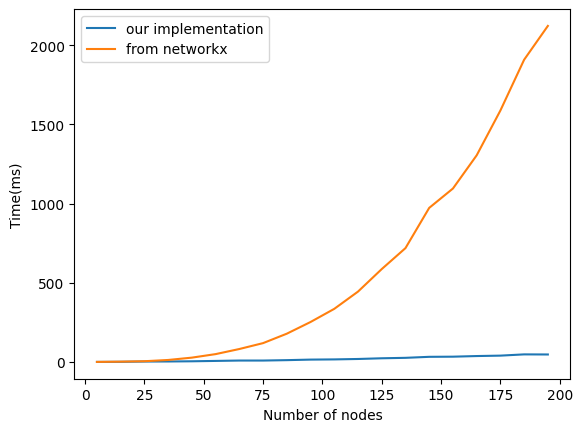

In [29]:
# Overall comparison with different amounts of nodes.

times_nxs, times_our = time_algorithm(floyd_warshall_predecessor_and_distance, custom_floyd_warshall, range(5, 200, 10), 30, True)
times_nxs, times_our = times_nxs.items(), times_our.items()
x1, y1 = zip(*times_our)
x2, y2 = zip(*times_nxs)
plt.plot(x1, y1, label="our implementation")
plt.plot(x2, y2, label="from networkx")
ylabel = plt.ylabel("Time(ms)")
xlabel = plt.xlabel("Number of nodes")
legend = plt.legend()

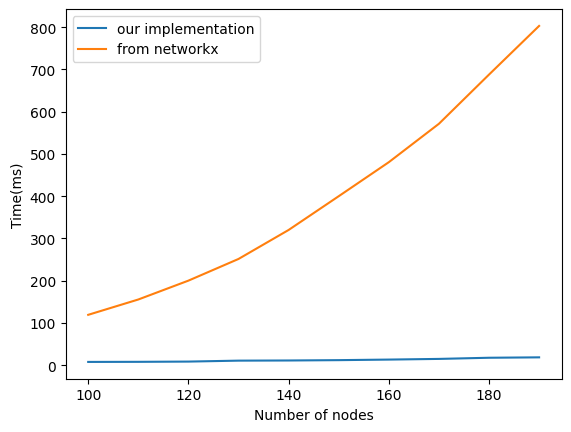

In [36]:
#Smaller comparison with average fullness.

times_nxs, times_our = time_algorithm(floyd_warshall_predecessor_and_distance, custom_floyd_warshall, range(100, 200, 10), 15, True)
times_nxs, times_our = times_nxs.items(), times_our.items()
x1, y1 = zip(*times_our)
x2, y2 = zip(*times_nxs)
plt.plot(x1, y1, label="our implementation")
plt.plot(x2, y2, label="from networkx")
ylabel = plt.ylabel("Time(ms)")
xlabel = plt.xlabel("Number of nodes")
legend = plt.legend()

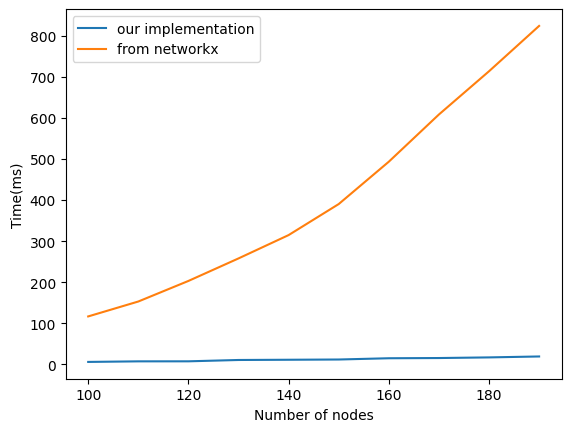

In [37]:
#Smaller comparison with low edge density.

times_nxs, times_our = time_algorithm(floyd_warshall_predecessor_and_distance, custom_floyd_warshall, range(100, 200, 10), 15, True, 0.3)
times_nxs, times_our = times_nxs.items(), times_our.items()
x1, y1 = zip(*times_our)
x2, y2 = zip(*times_nxs)
plt.plot(x1, y1, label="our implementation")
plt.plot(x2, y2, label="from networkx")
ylabel = plt.ylabel("Time(ms)")
xlabel = plt.xlabel("Number of nodes")
legend = plt.legend()

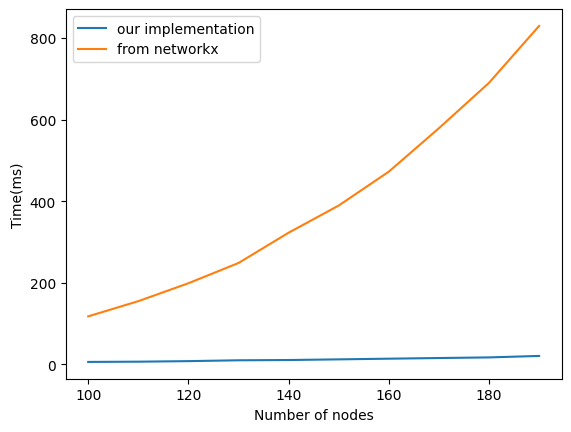

In [38]:
#Smaller comparison with high edge density.

times_nxs, times_our = time_algorithm(floyd_warshall_predecessor_and_distance, custom_floyd_warshall, range(100, 200, 10), 15, True, 0.8)
times_nxs, times_our = times_nxs.items(), times_our.items()
x1, y1 = zip(*times_our)
x2, y2 = zip(*times_nxs)
plt.plot(x1, y1, label="our implementation")
plt.plot(x2, y2, label="from networkx")
ylabel = plt.ylabel("Time(ms)")
xlabel = plt.xlabel("Number of nodes")
legend = plt.legend()

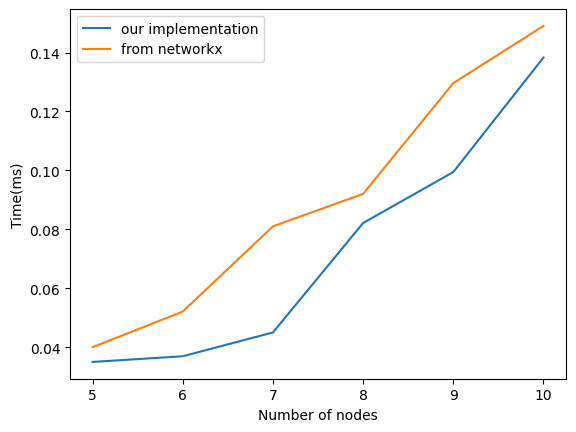

In [39]:
# Low node count to avoid negative cycles

times_nxs, times_our = time_algorithm(floyd_warshall_predecessor_and_distance, custom_floyd_warshall, range(5, 11), 1000, True)
times_nxs, times_our = times_nxs.items(), times_our.items()
x1, y1 = zip(*times_our)
x2, y2 = zip(*times_nxs)
plt.plot(x1, y1, label="our implementation")
plt.plot(x2, y2, label="from networkx")
ylabel = plt.ylabel("Time(ms)")
xlabel = plt.xlabel("Number of nodes")
legend = plt.legend()

### Conclusion:
##### Clearly our implementation of Floyd-Warshal is much faster. The difference is obvious throughout different amounts of nodes and edge densities.
##### We believe that main reason for that is that we detect negative cycles as fast as possible, while the networkx algorithm seems to do it much later, after lots of iterations. Such claim is supported by how the difference in speed is much lower on a small amount of nodes, where negative cycles are less prevalent.